In [1]:
# Import pacakages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import pycountry
import re
import ipywidgets as widgets
import cufflinks as cf
import geopandas as gpd

from ipywidgets import interact, interactive, fixed, interact_manual
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA


# Setting global enviorment parameters below for easy viewing
pd.set_option('display.max_columns', None) 
plt.rcParams['figure.figsize'] = [15, 9] 

In [2]:
# Learning about the Data
#
# Our data set was acquired from the world bank. Specifically, our chosen data set is on global population
# projections. We have taken every countries population data from every year between 1960-2050 (projected 
# data). However, due to limitations in the world banks data acquisition, there is a limit on the total amount
# of data we can pull at a grand total of ~2,500,000 cells. As a result we have left some data, which can 
# be derived, behind. Specifically, this data is consistant with the percentage of the population from any
# specific age groups in any given year. The resulting data that was pulled contains a significant amount of  
# missing data. This is due either to the way census' are carried out, 5 year intervals, or no data was every
# documented to begin with. As a result of inconsistant missing data across nearly all countries we will be
# forced to deal with and clean the necessary data as we go. Another caveat of this data is that it contains,
# non-nation data which must be cleaned (e.g. "Arab World"). This has been fixed by painstakingly removing
# them through manual search and entry.
# 
# Additionally, another data set has been incorporated which adds continents and their abbreviations to our 
# main data. This will provide our modelling with an easy way to classify by continent and provide more
# interesting.
#
# The World Bank country data can be found here:
# https://databank.worldbank.org/reports.aspx?source=Health%20Nutrition%20and%20Population%20Statistics%3A%20Population%20estimates%20and%20projections
#
# The Continent Code data can be found here:
# https://gist.github.com/stevewithington/20a69c0b6d2ff846ea5d35e5fc47f26c 

In [3]:
# Each row after data formatting will be in this order:
# Continent Names, Continent Codes, Country Number, Country Name, Country Code, Series Name, Series Code, and individual columns for every year from 1960-2050
#
# Continent Names : Contains the names of the continent associated with the country.
# Continent Codes : The continents respective two letter abbreviated code
# Country Number : The countries respective number
# Country Name : The countries respective name
# Country Code : The countries respective three letter abbreviated code
# Series Name : A description of the data in the remaining row from 1960-2050
# Series Code : Abbreviated version of the "Series Name" column
# 1960-2050 : The respective data for each individual year by its associated "Series Name" column.
#
# Another important note is that the data comes in consecutive rows of 90 per country. This means onee 
# row for each different "Series Name" column associated to the country. (All countries have 90 rows)

In [4]:
# For those interested in reproducing our data from the ground up, the following few cells will take the world
# banks data and provide an inefficent, but working way to create and properly label the data set with the 
# necessary continent codes attached.

In [5]:
# "Minimized Data 1960-2050.csv" Refers to the world bank data itself.
# "Country Codes with Continent.csv" Refers to 
#
#data_1960_2050 = pd.read_csv('./Datasets/Minimized Data 1960-2050.csv', low_memory=False)
#CCwC = pd.read_csv('./Datasets/Country Codes with Continent.csv', low_memory=False)
#
#data_1960_2050.insert(0, "Continent_Name", np.nan)
#data_1960_2050.insert(0, "Continent_Code", np.nan)
#data_1960_2050.insert(0, "Country_Number", np.nan)

In [6]:
#i = 1960
#string = ["Continent_Name", "Continent_Code", "Country_Number", "Country_Name", "Country_Code", "Series_Name", "Series_Code"]
#while i != 2051:
#    temp = "[" + str(i) + "]"
#    string.append(temp)
#    i = i + 1
#    
#data_1960_2050.columns = string

In [7]:
#for x in range(len(data_1960_2050)):
#    i = 90 # Length of Data set per country
#    for y in range(len(CCwC)):
#        if(data_1960_2050.loc[x, "Country_Code"] == CCwC.loc[y, "Three_Letter_Country_Code"]):
#            if(i != 0):
#                data_1960_2050.loc[x, "Continent_Name"] = CCwC.loc[y, "Continent_Name"]
#                data_1960_2050.loc[x, "Continent_Code"] = CCwC.loc[y, "Continent_Code"]
#                data_1960_2050.loc[x, "Country_Number"] = CCwC.loc[y, "Country_Number"]
#                i = i - 1

In [8]:
pop_data = pd.read_csv('./Datasets/Population Data 1960-2050.csv', low_memory=False)
pop_data = pop_data.replace('..', np.nan)
pop_data = pop_data.iloc[: , 1:] # Removing unnecessary column
pop_data.head(10)

,Continent_Name,Continent_Code,Country_Number,Country_Name,Country_Code,Series_Name,Series_Code,[1960],[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021],[2022],[2023],[2024],[2025],[2026],[2027],[2028],[2029],[2030],[2031],[2032],[2033],[2034],[2035],[2036],[2037],[2038],[2039],[2040],[2041],[2042],[2043],[2044],[2045],[2046],[2047],[2048],[2049],[2050]
0,Asia,AS,4.0,Afghanistan,AFG,Age dependency ratio (% of working-age populat...,SP.POP.DPND,81.617265593364,82.6886781269233,83.2893702677964,83.6040745667416,83.8538402296331,84.1305132205961,85.337606639107,86.3875817780626,87.2881796110479,88.004333820123,88.5257734411341,89.7775513950377,90.711207917884,91.3786718889649,91.8030471642632,91.9457639589236,92.9888574822643,93.858398071556,94.5105001444847,94.8159236718955,94.6074368846258,95.7623085653002,96.7238143522287,97.5152373392122,98.2848562519578,99.2641805972282,100.037992327902,100.318450831989,100.419936268638,100.852511182472,102.186695822177,101.855829678157,101.572891363737,101.497709604882,101.361665767309,100.751043096938,101.779455410549,102.821757539625,103.650785887861,104.275818919765,104.856398128094,104.476104431144,103.671182514941,102.663237607573,101.562370593157,100.349127298896,100.970943099336,101.600182463114,102.078658552986,102.249014354329,102.04582265028,100.224460810072,97.9259472109872,95.3387363003889,92.6491430408227,89.9540923341871,87.9417880743028,86.0007546392816,84.0776554602003,82.1097716001822,80.0882594983951,78.2140686091963,76.2873365602917,74.3682121084769,72.5347069038439,70.818707027286,69.2728455912696,67.811842050991,66.4260053997555,65.0929735927391,63.7996513768842,62.5877916751458,61.4162866626515,60.2818752139422,59.182682333386,58.1177761443717,57.1344740085998,56.1750226260573,55.244749483167,54.3515082631579,53.4987319337544,52.721641363705,51.9732864237122,51.2542813990082,50.5649528551787,49.905272496857,49.3091701493759,48.7358507892608,48.1851513162138,47.6569146420521,47.1525182056463
1,Asia,AS,4.0,Afghanistan,AFG,"Age dependency ratio, old",SP.POP.DPND.OL,5.08221355458813,5.13013875077877,5.1396410434319,5.11552596472367,5.06374943823744,4.98789855835,5.03818379040036,5.06247965853582,5.05905695854066,5.02527774105666,4.961263617462,5.00108321936102,5.01085032694929,4.99403609195624,4.95524993193465,4.8973899858217,4.93733610490956,4.94207927072837,4.91061339949012,4.84265971718334,4.73821354846004,4.80156958470389,4.81353830554338,4.76677564527408,4.65322466391202,4.46231971723597,4.54375628731268,4.59678804497462,4.61522776578655,4.59004259086774,4.51390235010915,4.52627613429353,4.55426302653287,4.6010207759227,4.66732341775973,4.7544225968921,4.78092518838318,4.78444369236508,4.76853617345827,4.73774444597141,4.69519414570861,4.64542399494426,4.5945113217023,4.5460364961842,4.50174411893789,4.46275357219977,4.52550492386492,4.5776088271441,4.62187756017232,4.66303425585248,4.70389192215768,4.71420886190398,4.72309440866141,4.72760222695028,4.72293656494244,4.7083204539433,4.7359880220469,4.75092727211326,4.75827277828347,4.76361649281109,4.77066404234554,4.79310389873702,4.81304782154357,4.83309464391658,4.85609762171484,4.88431018163558,4.9305392330175,4.97811237221119,5.02799948484703,5.08078716026558,5.13759646227234,5.20953818576817,5.28220675539213,5.35737057386191,5.43651858362534,5.52144418811474,5.62288654428234,5.72570298266211,5.83365888912406,5.95090641922628,6.08042828599966,6.22910451801117,6.38374301415072,6.54627153153927,6.71856043377268,6.90243289671151,7.10386591421077,7.31255821375793,7.5283209975396,7.74944602991995,7.97648707408324
2,Asia,AS,4.0,Afghanistan,AFG,"Age d

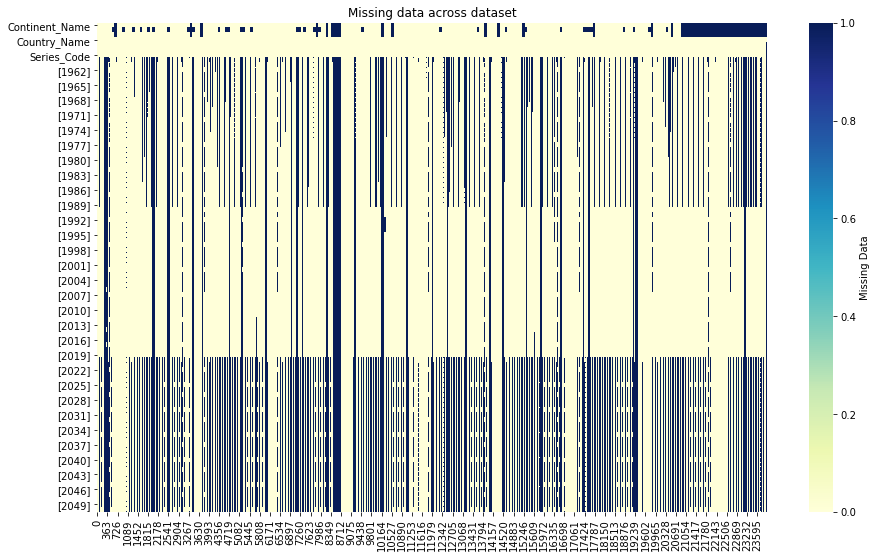

In [9]:
# Here we visualize our missing data
# Any data missing falls in to one of two catergories. Either the data was taken at a yearly interval and 
# thus some data is missing, or there is no data because the country does not have any records of the data. 
# Fixing these will be on a case by case basis depending on goal and the series we desire.

plt.figure()
sns.heatmap(pop_data.isnull().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.title("Missing data across dataset")
plt.savefig('./Images/Missing_Data_Across_Dataset.jpg', bbox_inches='tight')
plt.show()

In [10]:
# Creating a list of country codes

country_codes = []
country_names = []
for country in pycountry.countries:
    country_codes.append(country.alpha_3)
    country_names.append(country.name)
country_codes.sort(key=str.lower)
country_names.sort(key=str.lower)

In [11]:
# Here we separate our data into a data set containing only countries and another containing all other data.
# This second set includes data such as "Low Income", "Arab World", "IRF", and more.

country_data = pop_data[pop_data.Country_Code.isin(country_codes)]
non_country_data = pop_data[~pop_data.Country_Code.isin(country_codes)]
non_country_data = non_country_data.iloc[: , 3:] # Removing Continent Codes for non-Nations (Will be NA anyway)

In [12]:
country_data.head(120) # Checking to see if split is accurate

,Continent_Name,Continent_Code,Country_Number,Country_Name,Country_Code,Series_Name,Series_Code,[1960],[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021],[2022],[2023],[2024],[2025],[2026],[2027],[2028],[2029],[2030],[2031],[2032],[2033],[2034],[2035],[2036],[2037],[2038],[2039],[2040],[2041],[2042],[2043],[2044],[2045],[2046],[2047],[2048],[2049],[2050]
0,Asia,AS,4.0,Afghanistan,AFG,Age dependency ratio (% of working-age populat...,SP.POP.DPND,81.617265593364,82.6886781269233,83.2893702677964,83.6040745667416,83.8538402296331,84.1305132205961,85.337606639107,86.3875817780626,87.2881796110479,88.004333820123,88.5257734411341,89.7775513950377,90.711207917884,91.3786718889649,91.8030471642632,91.9457639589236,92.9888574822643,93.858398071556,94.5105001444847,94.8159236718955,94.6074368846258,95.7623085653002,96.7238143522287,97.5152373392122,98.2848562519578,99.2641805972282,100.037992327902,100.318450831989,100.419936268638,100.852511182472,102.186695822177,101.855829678157,101.572891363737,101.497709604882,101.361665767309,100.751043096938,101.779455410549,102.821757539625,103.650785887861,104.275818919765,104.856398128094,104.476104431144,103.671182514941,102.663237607573,101.562370593157,100.349127298896,100.970943099336,101.600182463114,102.078658552986,102.249014354329,102.04582265028,100.224460810072,97.9259472109872,95.3387363003889,92.6491430408227,89.9540923341871,87.9417880743028,86.0007546392816,84.0776554602003,82.1097716001822,80.0882594983951,78.2140686091963,76.2873365602917,74.3682121084769,72.5347069038439,70.818707027286,69.2728455912696,67.811842050991,66.4260053997555,65.0929735927391,63.7996513768842,62.5877916751458,61.4162866626515,60.2818752139422,59.182682333386,58.1177761443717,57.1344740085998,56.1750226260573,55.244749483167,54.3515082631579,53.4987319337544,52.721641363705,51.9732864237122,51.2542813990082,50.5649528551787,49.905272496857,49.3091701493759,48.7358507892608,48.1851513162138,47.6569146420521,47.1525182056463
1,Asia,AS,4.0,Afghanistan,AFG,"Age dependency ratio, old",SP.POP.DPND.OL,5.08221355458813,5.13013875077877,5.1396410434319,5.11552596472367,5.06374943823744,4.98789855835,5.03818379040036,5.06247965853582,5.05905695854066,5.02527774105666,4.961263617462,5.00108321936102,5.01085032694929,4.99403609195624,4.95524993193465,4.8973899858217,4.93733610490956,4.94207927072837,4.91061339949012,4.84265971718334,4.73821354846004,4.80156958470389,4.81353830554338,4.76677564527408,4.65322466391202,4.46231971723597,4.54375628731268,4.59678804497462,4.61522776578655,4.59004259086774,4.51390235010915,4.52627613429353,4.55426302653287,4.6010207759227,4.66732341775973,4.7544225968921,4.78092518838318,4.78444369236508,4.76853617345827,4.73774444597141,4.69519414570861,4.64542399494426,4.5945113217023,4.5460364961842,4.50174411893789,4.46275357219977,4.52550492386492,4.5776088271441,4.62187756017232,4.66303425585248,4.70389192215768,4.71420886190398,4.72309440866141,4.72760222695028,4.72293656494244,4.7083204539433,4.7359880220469,4.75092727211326,4.75827277828347,4.76361649281109,4.77066404234554,4.79310389873702,4.81304782154357,4.83309464391658,4.85609762171484,4.88431018163558,4.9305392330175,4.97811237221119,5.02799948484703,5.08078716026558,5.13759646227234,5.20953818576817,5.28220675539213,5.35737057386191,5.43651858362534,5.52144418811474,5.62288654428234,5.72570298266211,5.83365888912406,5.95090641922628,6.08042828599966,6.22910451801117,6.38374301415072,6.54627153153927,6.71856043377268,6.90243289671151,7.10386591421077,7.31255821375793,7.5283209975396,7.74944602991995,7.97648707408324
2,Asia,AS,4.0,Afghanistan,AFG,"Age d

In [13]:
non_country_data.head(120) # Checking to see if split is accurate

,Country_Name,Country_Code,Series_Name,Series_Code,[1960],[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021],[2022],[2023],[2024],[2025],[2026],[2027],[2028],[2029],[2030],[2031],[2032],[2033],[2034],[2035],[2036],[2037],[2038],[2039],[2040],[2041],[2042],[2043],[2044],[2045],[2046],[2047],[2048],[2049],[2050]
630,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,88.06112205164,89.4895108163163,90.7824558771063,91.8989500408246,92.7280061443775,93.2012930138842,94.087532755907,94.4859240488432,94.544615403454,94.4342534394932,94.2266643745616,94.5232110266817,94.5916608051277,94.4822953645836,94.2471390363775,93.9376995597172,93.803986457377,93.5599438081628,93.2248262893934,92.7926339727742,92.2575196188023,91.9656578546825,91.5350620214575,90.9953682327702,90.3831316021733,89.7191273477264,89.4438357883841,89.0285578821035,88.5170660482334,87.9145337739656,87.3320530013089,86.5101699445605,85.8304438692499,84.704228399562,83.4326220453293,81.8208504077921,80.5449266915477,79.1986694279309,77.8170131435407,76.4227835668322,75.0173343309576,73.6057527561146,72.18209603725,70.7701237028073,69.4003537532049,68.0988262244385,66.9023290826331,65.7843056315348,64.7785025338816,63.9138327800629,63.2016211242295,62.5723284619495,62.0893243343428,61.7307948697144,61.4465810422326,61.1953066707489,61.283403446682,61.2533630506395,61.1645819704013,61.0818013387275,61.019962983148,60.829896452621,60.681146097193,60.5174999070387,60.250999776366,59.843405894957,59.4079889376226,58.8468742570022,58.2040910558717,57.5575364885441,56.9548343270482,56.4431811186312,55.9599005399144,55.5207923355043,55.1303437406016,54.7932919427895,54.5737306162385,54.3882405917174,54.2524628643581,54.1768445958267,54.1635290280346,54.2441783119108,54.3563323234361,54.5022218543154,54.6771558210053,54.8749650103232,55.1035089860824,55.3336141517315,55.5643422212161,55.7915346893762,56.0120656305736
631,Arab World,ARB,"Age dependency ratio, old",SP.POP.DPND.OL,6.59195408307987,6.70090074366887,6.79327971905438,6.86732593028292,6.91922151681126,6.94779074720844,7.01559082118739,7.05347127100655,7.07011677104574,7.07506501358867,7.07355966713691,7.11832725337112,7.14820987382225,7.16107292512336,7.15334083385924,7.12560208428215,7.11348093859674,7.0810216954807,7.03508639642727,6.98255604877118,6.92803253513746,6.90401956955471,6.87098116094258,6.8328328012533,6.79374040302333,6.7571436478586,6.75894075266777,6.7590096996625,6.76125834506832,6.76789629532067,6.75897576068469,6.79859452328479,6.88014284963391,6.90718743531979,6.93127370540459,6.91586520022699,6.94686757653477,6.9680003972479,6.98180699985983,6.9881164011666,6.9871194426484,6.9756676140615,6.9563601413223,6.92934736758178,6.8929686599926,6.84875837740397,6.80875900444734,6.75955726571105,6.71179791817589,6.67681857378858,6.66162414181123,6.66872911565331,6.68688531042261,6.72070535687589,6.77649938032406,6.85818707211253,6.98148098233184,7.12144985748971,7.27380192381238,7.43200320011483,7.59307165027408,7.77289869524465,7.95267533539854,8.13659435390806,8.32926012411065,8.53382871398852,8.75551407067243,8.97983853102697,9.2095792383192,9.44735372419912,9.69598982239725,9.94965637050367,10.2079923767089,10.474438001793,10.751464414661,11.0415061891482,11.3312952272521,11.6270485883368,11.9354928378102,12.2641564528881,12.6176097465762,12.9750648954027,13.3475510934054,13.734951831815,14.1351286360119,14.5470057281549,14.9489352712508,15.3520425351572,15.7588941463234,16.1719816705628,16.5930502916949
632,Arab World,ARB,"Age dependency ratio, young",SP.POP.DPND.YG,81.3241959797136,82.6261975934145,83.78

In [14]:
# Below, and in the next few cells, we begin to segment the data in a way that will allow us 
# to efficently visualize it. This is done by preprocessing them into smaller dataframes with 
# only the infromation we need to conduct our analysis and visualizations.

#totals
pop_total = country_data[country_data.Series_Code == "SP.POP.TOTL"] #Population Totals
pop_growth = country_data[country_data.Series_Code == "SP.POP.GROW"] #Population Growth
pop_migration = country_data[country_data.Series_Code == "SM.POP.NETM"] #Net Migration
pop_rural = country_data[country_data.Series_Code == 'SP.RUR.TOTL'] #rural population
pop_urban = country_data[country_data.Series_Code == 'SP.URB.TOTL'] #urban population

In [15]:
# Here we extract a single row of data that represents the total global data of that series description.

# Extracting all 90 rows of world data.
world_data = non_country_data[non_country_data.Country_Name == "World"]

# Extracinting specific series data for modelling and visualization.
world_total = non_country_data[non_country_data.Series_Code == "SP.POP.TOTL"] 
world_total = world_total[world_total.Country_Code == "WLD"]

# Extracinting specific series data for modelling and visualization.
world_growth = non_country_data[non_country_data.Series_Code == "SP.POP.GROW"] 
world_growth = world_growth[world_growth.Country_Code == "WLD"] 

In [16]:
#ratios
pop_birth_rate = country_data[country_data.Series_Code == 'SP.DYN.CBRT.IN'] #Birth rate, crude (per 1,000 people)
pop_death_rate = country_data[country_data.Series_Code == 'SP.DYN.CDRT.IN'] #Death rate, crude (per 1,000 people)
pop_male = country_data[country_data.Series_Code == 'SP.POP.TOTL.MA.ZS'] #Population, male (% of total population)
pop_female = country_data[country_data.Series_Code == 'SP.POP.TOTL.FE.ZS'] #Population, female (% of total population)
pop_age_dependency_w = country_data[country_data.Series_Code == 'SP.POP.DPND'] #Age dependency ratio (% of working-age population)
pop_age_dependency_o = country_data[country_data.Series_Code == 'SP.POP.DPND.OL'] #Age dependency ratio, old
pop_age_dependency_y = country_data[country_data.Series_Code == 'SP.POP.DPND.YG'] #Age dependency ratio, young
pop_life_expec =  country_data[country_data.Series_Code == 'SP.DYN.LE00.IN']

In [17]:
# male_totals = country_data[country_data.Series_Code == "SP.POP.TOTL.MA.IN"] #Male Population
# female_totals = country_data[country_data.Series_Code == "SP.POP.TOTL.FE.IN"] #Female Population
# rural_totals = country_data[country_data.Series_Code == "SP.RUR.TOTL"] #Rural Population Total
# urban_totals = country_data[country_data.Series_Code == "SP.URB.TOTL"] #Urban Population Total

In [18]:
pop_total.head(10)

,Continent_Name,Continent_Code,Country_Number,Country_Name,Country_Code,Series_Name,Series_Code,[1960],[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021],[2022],[2023],[2024],[2025],[2026],[2027],[2028],[2029],[2030],[2031],[2032],[2033],[2034],[2035],[2036],[2037],[2038],[2039],[2040],[2041],[2042],[2043],[2044],[2045],[2046],[2047],[2048],[2049],[2050]
62,Asia,AS,4.0,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967,9169406,9351442,9543200,9744772,9956318,10174840,10399936,10637064,10893772,11173654,11475450,11791222,12108963,12412960,12689164,12943093,13171294,13341199,13411060,13356500,13171679,12882518,12537732,12204306,11938204,11736177,11604538,11618008,11868873,12412311,13299016,14485543,15816601,17075728,18110662,18853444,19357126,19737770,20170847,20779957,21606992,22600774,23680871,24726689,25654274,26433058,27100542,27722281,28394806,29185511,30117411,31161378,32269592,33370804,34413603,35383028,36296111,37171922,38041757,38928341,39835000,40754000,41681000,42609000,43532000,44449000,45364000,46275000,47185000,48094000,49000000,49904000,50804000,51699000,52587000,53469000,54343000,55209000,56065000,56912000,57748000,58574000,59387000,60188000,60974000,61746000,62503000,63245000,63972000,64683000
152,Europe,EU,8.0,Albania,ALB,"Population, total",SP.POP.TOTL,1608800,1659800,1711319,1762621,1814135,1864791,1914573,1965598,2022272,2081695,2135479,2187853,2243126,2296752,2350124,2404831,2458526,2513546,2566266,2617832,2671997,2726056,2784278,2843960,2904429,2964762,3022635,3083605,3142336,3227943,3286542,3266790,3247039,3227287,3207536,3187784,3168033,3148281,3128530,3108778,3089027,3060173,3051010,3039616,3026939,3011487,2992547,2970017,2947314,2927519,2913021,2905195,2900401,2895092,2889104,2880703,2876101,2873457,2866376,2854191,2837743,2832000,2824000,2816000,2807000,2798000,2789000,2779000,2769000,2759000,2748000,2736000,2724000,2711000,2696000,2681000,2665000,2647000,2629000,2610000,2591000,2571000,2550000,2529000,2508000,2486000,2465000,2443000,2421000,2399000,2377000
242,Africa,AF,12.0,Algeria,DZA,"Population, total",SP.POP.TOTL,11057864,11336336,11619828,11912800,12221675,12550880,12902626,13275020,13663581,14061724,14464992,14872253,15285992,15709831,16149018,16607706,17085799,17582899,18102266,18647801,19221659,19824297,20452901,21101875,21763578,22431507,23102386,23774287,24443472,25106192,25758872,26400468,27028330,27635517,28213777,28757788,29266415,29742980,30192750,30623406,31042238,31451513,31855110,32264159,32692153,33149720,33641007,34166976,34730604,35333882,35977451,36661438,37383899,38140135,38923688,39728020,40551398,41389174,42228415,43053054,43851043,44617000,45350000,46053000,46731000,47388000,48022000,48634000,49226000,49801000,50361000,50908000,51444000,51971000,52494000,53016000,53537000,54059000,54583000,55110000,55640000,56174000,56711000,57250000,57789000,58326000,58859000,59388000,59911000,60423000,60923000
332,Oceania,OC,16.0,American Samoa,ASM,"Population, total",SP.POP.TOTL,20127,20605,21246,22029,22850,23675,24473,25235,25980,26698,27362,27982,28564,29103,29595,30045,30455,30834,31262,31842,32648,33697,34969,36413,37946,39521,41114,42741,44346,45894,47351,48682,49900,51025,52099,53158,54209,55227,56180,57049,57816,58496,59077,59495,59684,59557,59109,58367,57490,56675,56084,55755,55669,55717,55791,55806,55739,55617,55461,55312,55197,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,54000,54000,54000,54000,54000,54000,54000,54000,54000,54000,54000,54000,54000,54000,54000
422,Europe,EU,20.0,Andorra,AND,"Population, total",SP.POP.TOTL,13410,14378,15379,16407,17466,18542,196

In [19]:
# This contains a single line of information which capture the entire global population from 1960-2020
# and the subsequent projected data from 2021-2050.

world_total.head(1)

,Country_Name,Country_Code,Series_Name,Series_Code,[1960],[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021],[2022],[2023],[2024],[2025],[2026],[2027],[2028],[2029],[2030],[2031],[2032],[2033],[2034],[2035],[2036],[2037],[2038],[2039],[2040],[2041],[2042],[2043],[2044],[2045],[2046],[2047],[2048],[2049],[2050]
20582,World,WLD,"Population, total",SP.POP.TOTL,3032156070,3071596055,3124561005,3189655687,3255145692,3322046795,3392097729,3461619724,3532782993,3606553753,3681975908,3760516757,3836900801,3912984371,3988487336,4062507027,4135432265,4207786422,4281339378,4356778367,4432963653,4511164132,4592387213,4674330282,4755996689,4839176734,4924747934,5012556248,5101287675,5189977062,5280046096,5368139468,5452576447,5537885552,5622085788,5706753900,5789655609,5872286683,5954005906,6034491620,6114332517,6193671694,6272753009,6351882385,6431551721,6511748273,6592734559,6674203697,6757020825,6839574233,6921877071,7002880914,7085790438,7169675197,7254292848,7339076654,7424484741,7509410228,7592475615,7673345391,7752840547,7831742000,7910003000,7987314000,8063642000,8138971000,8213276000,8286546000,8358787000,8429999000,8500190000,8569347000,8637443000,8704424000,8770284000,8835051000,8898735000,8961396000,9023031000,9083646000,9143220000,9201714000,9259081000,9315314000,9370366000,9424214000,9476828000,9528225000,9578391000,9627322000,9674665000


In [20]:
# Another single instance of growth percentage trends.

world_growth.head()

,Country_Name,Country_Code,Series_Name,Series_Code,[1960],[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021],[2022],[2023],[2024],[2025],[2026],[2027],[2028],[2029],[2030],[2031],[2032],[2033],[2034],[2035],[2036],[2037],[2038],[2039],[2040],[2041],[2042],[2043],[2044],[2045],[2046],[2047],[2048],[2049],[2050]
20577,World,WLD,Population growth (annual %),SP.POP.GROW,NaN,1.30072410817561,1.7243462047616,2.08332248580949,2.05319982551457,2.05524143402917,2.10866788828604,2.04952806653054,2.0557795099968,2.08817694565934,2.09125276275897,2.13311686340344,2.03121137162374,1.98294336877748,1.92954936287425,1.8558336723775,1.79507967654773,1.74961533313858,1.74802018504161,1.7620417897177,1.74866104222924,1.76406767844979,1.80049048590014,1.78432403887979,1.74712530080474,1.74895086012958,1.76830078138659,1.78300118456379,1.77018316822685,1.73856862522462,1.73544185116863,1.66842050994094,1.57292819054604,1.56456504240188,1.52044016094899,1.50599110708553,1.45269465711498,1.427219157415,1.39160819986147,1.35179096679923,1.32307577883421,1.2975934295266,1.27680831188725,1.26147763010064,1.25426340053367,1.24692384480321,1.24369497414078,1.23574121285958,1.24085406678891,1.22174269013,1.20333276891564,1.17025832977265,1.18393451235548,1.18384476275419,1.18021596062547,1.16873977624677,1.16374431044332,1.14385698082209,1.10615060940842,1.06513053318513,1.03599084817998,1.01771025112249,0.999279598332009,0.977382688729705,0.955615367068319,0.934180857731533,0.912953246792497,0.892092266228488,0.871786628590485,0.851941794903979,0.832633550727579,0.81359357849648,0.794646313190484,0.775472555940453,0.756626745204514,0.738482357013751,0.720810779700074,0.704156264907311,0.687783465879647,0.67178091264455,0.655837975191915,0.639752734813342,0.62343819857908,0.60732809228044,0.59098383586425,0.57466271861739,0.558285285117677,0.542343915073687,0.526498901946582,0.510847803143562,0.491756689970487


In [21]:
print(pop_total.Country_Name.tolist()) # Printed values of all countries in our dataframe

['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia', 'Gabon', 'Gambia, The', 'Georgia', 'Germany', 'Ghana', 'Gibraltar'

In [22]:
print(pop_data.dtypes) # Checking types before visualization.

Continent_Name     object
Continent_Code     object
Country_Number    float64
Country_Name       object
Country_Code       object
                   ...   
[2046]             object
[2047]             object
[2048]             object
[2049]             object
[2050]             object
Length: 98, dtype: object


In [23]:
# Over the next few cell blocks we present some simple methods to present our visualizations later.

In [24]:
def preparePlot(dataframe):
    string = dataframe['Country_Name'].tolist()
    dataframe = dataframe.T
    dataframe = dataframe.iloc[8:]
    dataframe = dataframe.astype('float64')
    dataframe.columns = string
    return dataframe

In [25]:
def pop_over_time_plot(country):
    pop_total_plot.loc[country].iplot(
                    xTitle='Year', 
                    yTitle='Population of {}'.format(country),
                    title='Population Over Time')

In [26]:
def pop_rural_over_time_plot(country):
    pop_rural_plot.loc[country].iplot(
                    xTitle='Year', 
                    yTitle='Population of {}'.format(country),
                    title='Rural Population Over Time')

In [27]:
def pop_urban_over_time_plot(country):
    pop_urban_plot.loc[country].iplot(
                    xTitle='Year', 
                    yTitle='Population of {}'.format(country),
                    title='Urban Population Over Time')

C:\Users\GIGA\anaconda3\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

C:\Users\GIGA\anaconda3\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

C:\Users\GIGA\anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\GIGA\anaconda3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



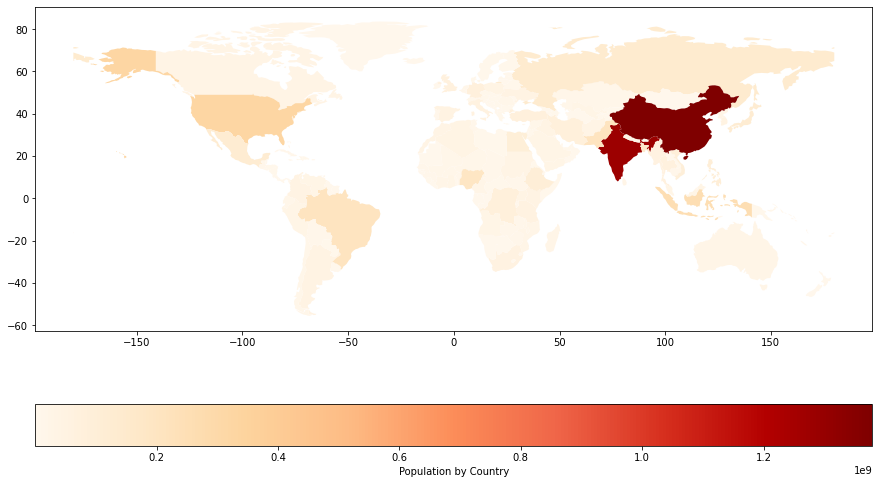

In [28]:
# Here we produce a heatmap of the global population at its current state. We can see which countries are
# exceptionally populated.

world_gpd = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_gpd = world_gpd.merge(pop_total, left_on="iso_a3", right_on="Country_Code")
world_gpd.plot(column='pop_est', cmap='OrRd', legend=True, legend_kwds={'label': "Population by Country",
                        'orientation': "horizontal"});
plt.savefig('./Images/World_Population_Heatmap.jpg', bbox_inches='tight')

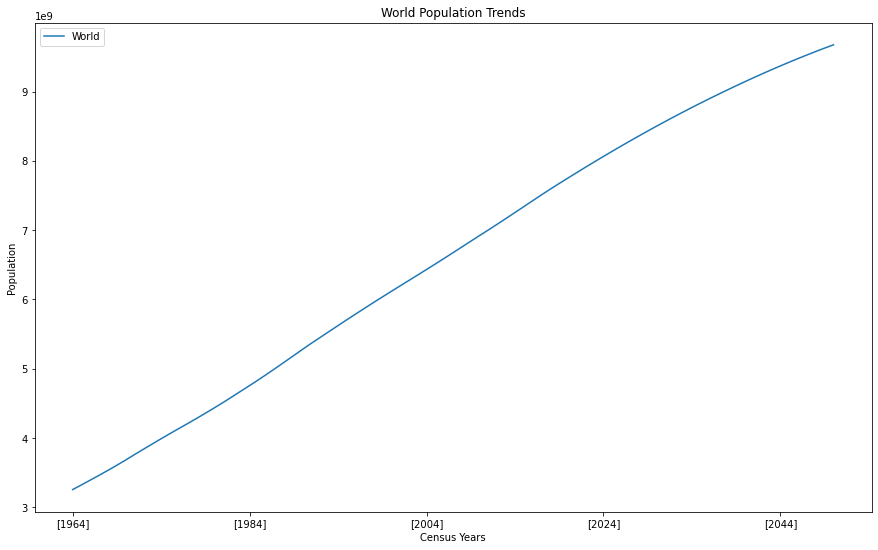

In [29]:
# Plotting the worlds population total by year including projections past 2021.

world_total_plot = preparePlot(world_total)
world_total_plot.plot(title = "World Population Trends")
plt.ylabel("Population")
plt.xlabel("Census Years")
plt.legend(["World"])
plt.savefig('./Images/World_Population_Trends.jpg', bbox_inches='tight')

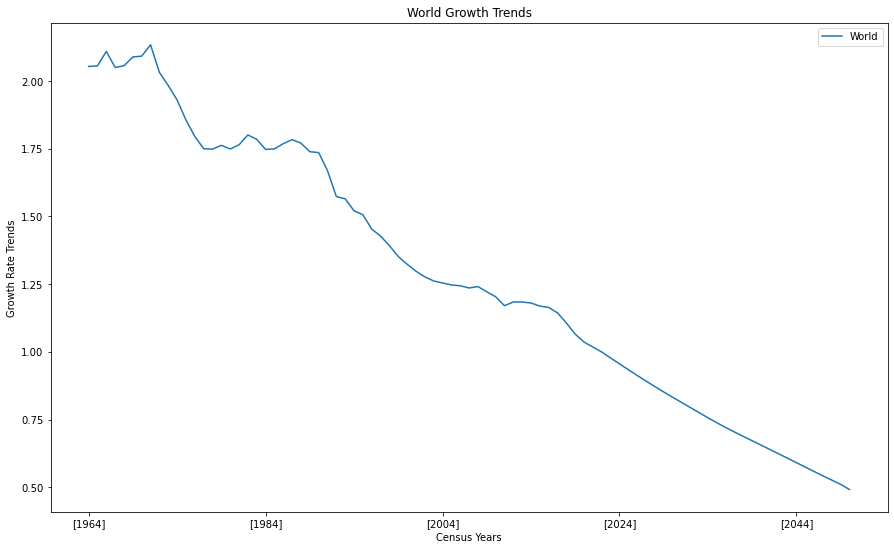

In [30]:
# Plotting the worlds population growth by year, this including projections past 2021.

world_growth_plot = preparePlot(world_growth)
world_growth_plot.plot(title = "World Growth Trends")
plt.ylabel("Growth Rate Trends")
plt.xlabel("Census Years")
plt.legend(["World"])
plt.savefig('./Images/World_Growth_Trends.jpg', bbox_inches='tight')

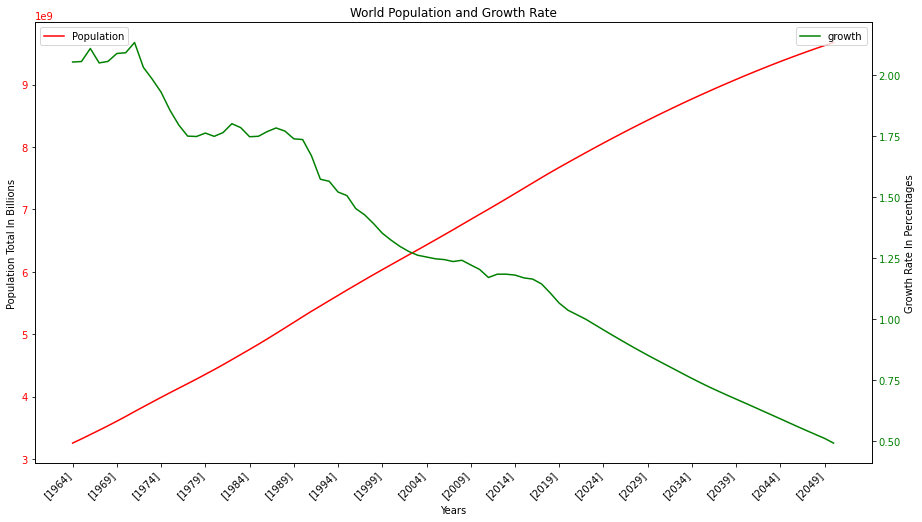

In [31]:
# General visualizations - world population vs growth rate
# world_total_plt = preparePlot(world_total)
world_total_plot = world_total_plot.rename(columns={"World": "population"})
# world_growth_plt = preparePlot(world_growth)
world_growth_plot = world_growth_plot.rename(columns={"World": "growth"})

world_data = pd.merge(world_total_plot, world_growth_plot, left_index=True, right_index=True)


fig, ax = plt.subplots()

ax.plot(world_data.index, world_data['population'], color='red',label='Population')
ax.tick_params(axis='y', labelcolor='red')
ax.set_xlabel('Years')  
ax.set_ylabel('Population Total In Billions') 
ax.legend()
ax2 = ax.twinx()


ax2.plot(world_data.index, world_data['growth'], color='green', label='growth')
ax2.tick_params(axis='y', labelcolor='green')  
ax2.set_ylabel('Growth Rate In Percentages') 
ax2.legend()
fig.autofmt_xdate(rotation=45)
ax_ticks = np.array(ax.get_xticks())
ax.set_xticks(ax_ticks[::5])
plt.title("World Population and Growth Rate")
plt.savefig('./Images/World_Population_and_Growth_Rate.jpg', bbox_inches='tight')
plt.show()

In [32]:
pop_migration.head(10)

,Continent_Name,Continent_Code,Country_Number,Country_Name,Country_Code,Series_Name,Series_Code,[1960],[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021],[2022],[2023],[2024],[2025],[2026],[2027],[2028],[2029],[2030],[2031],[2032],[2033],[2034],[2035],[2036],[2037],[2038],[2039],[2040],[2041],[2042],[2043],[2044],[2045],[2046],[2047],[2048],[2049],[2050]
3,Asia,AS,4.0,Afghanistan,AFG,Net migration,SM.POP.NETM,NaN,NaN,-20000,NaN,NaN,NaN,NaN,-20000,NaN,NaN,NaN,NaN,-20000,NaN,NaN,NaN,NaN,-1153959,NaN,NaN,NaN,NaN,-3345095,NaN,NaN,NaN,NaN,-1525351,NaN,NaN,NaN,NaN,3076383,NaN,NaN,NaN,NaN,-867540,NaN,NaN,NaN,NaN,744193,NaN,NaN,NaN,NaN,-1046361,NaN,NaN,NaN,NaN,521769,NaN,NaN,NaN,NaN,-314602,NaN,NaN,NaN,NaN,-300000,NaN,NaN,NaN,NaN,-330092,NaN,NaN,NaN,NaN,-311796,NaN,NaN,NaN,NaN,-311802,NaN,NaN,NaN,NaN,-311082,NaN,NaN,NaN,NaN,-310076,NaN,NaN,NaN
93,Europe,EU,8.0,Albania,ALB,Net migration,SM.POP.NETM,NaN,NaN,-99,NaN,NaN,NaN,NaN,-99,NaN,NaN,NaN,NaN,-99,NaN,NaN,NaN,NaN,-99,NaN,NaN,NaN,NaN,-99,NaN,NaN,NaN,NaN,-99,NaN,NaN,NaN,NaN,-443212,NaN,NaN,NaN,NaN,-179606,NaN,NaN,NaN,NaN,-176774,NaN,NaN,NaN,NaN,-217358,NaN,NaN,NaN,NaN,-136590,NaN,NaN,NaN,NaN,-69998,NaN,NaN,NaN,NaN,-69998,NaN,NaN,NaN,NaN,-55000,NaN,NaN,NaN,NaN,-40000,NaN,NaN,NaN,NaN,-40000,NaN,NaN,NaN,NaN,-40000,NaN,NaN,NaN,NaN,-40000,NaN,NaN,NaN
183,Africa,AF,12.0,Algeria,DZA,Net migration,SM.POP.NETM,NaN,NaN,-282941,NaN,NaN,NaN,NaN,-121335,NaN,NaN,NaN,NaN,-253436,NaN,NaN,NaN,NaN,-224833,NaN,NaN,NaN,NaN,-81020,NaN,NaN,NaN,NaN,-93302,NaN,NaN,NaN,NaN,-128679,NaN,NaN,NaN,NaN,-164413,NaN,NaN,NaN,NaN,-205228,NaN,NaN,NaN,NaN,-357340,NaN,NaN,NaN,NaN,-143268,NaN,NaN,NaN,NaN,-50002,NaN,NaN,NaN,NaN,-50002,NaN,NaN,NaN,NaN,-50002,NaN,NaN,NaN,NaN,-50002,NaN,NaN,NaN,NaN,-50002,NaN,NaN,NaN,NaN,-50002,NaN,NaN,NaN,NaN,-50002,NaN,NaN,NaN
273,Oceania,OC,16.0,American Samoa,ASM,Net migration,SM.POP.NETM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,Europe,EU,20.0,Andorra,AND,Net migration,SM.POP.NETM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,Africa,AF,24.0,Angola,AGO,Net migration,SM.POP.NETM,NaN,NaN,-296717,NaN,NaN,NaN,NaN,-587286,NaN,NaN,NaN,NaN,199800,NaN,NaN,NaN,NaN,199800,NaN,NaN,NaN,NaN,234148,NaN,NaN,NaN,NaN,188491,NaN,NaN,NaN,NaN,142812,NaN,NaN,NaN,NaN,199800,NaN,NaN,NaN,NaN,261100,NaN,NaN,NaN,NaN,357301,NaN,NaN,NaN,NaN,166267,NaN,NaN,NaN,NaN,32066,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,-5002,NaN,NaN,NaN,NaN,-5002,NaN,NaN,NaN,NaN,-4997,NaN,NaN,NaN,NaN,-4998,NaN,NaN,NaN,NaN,-5000,NaN,NaN,NaN
543,North America,NaN,28.0,Antigua and Barbuda,ATG,Net migration,SM.POP.NETM,NaN,NaN,-1880,NaN,NaN,NaN,NaN,-1202,NaN,NaN,NaN,NaN,-7018,NaN,NaN,NaN,NaN,-4428,NaN,NaN,NaN,NaN,-3763,NaN,NaN,NaN,NaN,-2890,NaN,NaN,NaN,NaN,2231,NaN,NaN,NaN,NaN,2469,NaN,NaN,NaN,NaN,252,NaN,NaN,NaN,NaN,1887,NaN,NaN,NaN,NaN,943,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
723,South America,SA,32.0,Argentina,ARG,Net migration,SM.POP.NETM,NaN,NaN,1

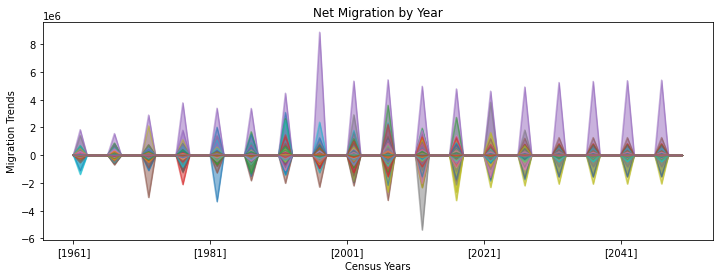

In [33]:
# General visualizations - Migration Trends

migration_plot = preparePlot(pop_migration)
fig, axs = plt.subplots(figsize=(12, 4))  
migration_plot.plot.area(ax = axs, stacked = False)
axs.get_legend().remove()
axs.set_xlabel("Census Years")
axs.set_ylabel("Migration Trends")
axs.set_title("Net Migration by Year")
plt.savefig('./Images/World_Population_Migration_Trends.jpg', bbox_inches='tight')

In [34]:
# General visualizations - Total Population of each country

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

pop_total_plot = pop_total.drop(columns=['Country_Code', 'Series_Name', 'Series_Code', 'Continent_Name', 'Continent_Code','Country_Number'])
pop_total_plot = pop_total_plot.set_index('Country_Name')
interact(pop_over_time_plot, country=pop_total_plot.index)

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'American …

<function __main__.pop_over_time_plot(country)>

In [35]:
# General visualizations - Rural Population of each country
pop_rural_plot = pop_rural.drop(columns=['Country_Code', 'Series_Name', 'Series_Code', 'Continent_Name', 'Continent_Code','Country_Number'])
pop_rural_plot = pop_rural_plot.set_index('Country_Name')

interact(pop_rural_over_time_plot, country=pop_rural_plot.index)

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'American …

<function __main__.pop_rural_over_time_plot(country)>

In [36]:
# General visualizations - Rural Population of each country

pop_urban_plot = pop_urban.drop(columns=['Country_Code', 'Series_Name', 'Series_Code', 'Continent_Name', 'Continent_Code','Country_Number'])
pop_urban_plot = pop_urban_plot.set_index('Country_Name')
interact(pop_urban_over_time_plot, country=pop_urban_plot.index)

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'American …

<function __main__.pop_urban_over_time_plot(country)>

In [37]:
pop_growth.head(10)

,Continent_Name,Continent_Code,Country_Number,Country_Name,Country_Code,Series_Name,Series_Code,[1960],[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021],[2022],[2023],[2024],[2025],[2026],[2027],[2028],[2029],[2030],[2031],[2032],[2033],[2034],[2035],[2036],[2037],[2038],[2039],[2040],[2041],[2042],[2043],[2044],[2045],[2046],[2047],[2048],[2049],[2050]
57,Asia,AS,4.0,Afghanistan,AFG,Population growth (annual %),SP.POP.GROW,NaN,1.89849871864013,1.96580482827753,2.02983029774638,2.09020770865721,2.14763884614552,2.17106818556713,2.18816458929405,2.25448537032307,2.38467438052838,2.53674360272129,2.66512850460028,2.71453854729245,2.65905658521727,2.47951659114535,2.20073128110818,1.98138858740406,1.74774777496605,1.2817151973175,0.522282314962146,-0.407658191922243,-1.3934163397202,-2.21977958780843,-2.71285408602014,-2.69538173169936,-2.2045162396444,-1.70675553634083,-1.12798940191383,0.116007964937545,2.13629507171115,4.47695437953718,6.90012448590171,8.54610700459867,8.790896706627,7.65979553393712,5.88427856371589,4.0194777158615,2.63650176396731,1.9473438616857,2.17042851112236,2.97505722281038,3.90280496415438,4.4967187466326,4.66834379545461,4.32155951673842,3.68269988149014,2.9905238360968,2.49383039084495,2.26827304079294,2.39697830237036,2.74661463795293,3.14310555651301,3.40760003260595,3.49459192739625,3.35560233082199,3.07705362914441,2.77803478841236,2.54783303994568,2.38430907940751,2.31307334941778,2.30381209309418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,Europe,EU,8.0,Albania,ALB,Population growth (annual %),SP.POP.GROW,NaN,3.12085537059054,3.05673050279088,2.95374876199632,2.88068642624326,2.75402123804227,2.63456387954101,2.63019034549493,2.84251071048949,2.8960833877323,2.55085117829323,2.4229720170788,2.49497310670312,2.36255222384825,2.29721417566909,2.3011538096943,2.20823525497527,2.21325217885547,2.07574189532527,1.98945701957156,2.04796386136191,2.00297430640894,2.11327178253342,2.12088533357751,2.10393661802013,2.05599460887143,1.93322081083734,1.99703995612751,1.88671052887888,2.68786198874035,1.79908559333186,-0.602809679480026,-0.606434726201759,-0.610165792730247,-0.613880506929603,-0.617703658436963,-0.62151139901728,-0.625430096900055,-0.629334392525913,-0.63335227398725,-0.637356833943492,-0.93847042771206,-0.299876697084691,-0.374149169291299,-0.417931377925999,-0.511790116421897,-0.630911244851673,-0.75571875541991,-0.767342959142321,-0.673894046451936,-0.49646196338738,-0.269017331764615,-0.165151040121679,-0.183211384606402,-0.207046999760594,-0.291205786840436,-0.159880412127734,-0.0919722937442495,-0.246732042281782,-0.426007367032238,-0.577942252408581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,Africa,AF,12.0,Algeria,DZA,Population growth (annual %),SP.POP.GROW,NaN,2.48712929819037,2.46998072150025,2.49005030450492,2.55975624327374,2.65797679148509,2.76400739009282,2.84532171758301,2.8849898337937,2.872252416368,2.82748891490154,2.77658767399254,2.7439591357089,2.73498412645034,2.75725481360539,2.80075616482425,2.83808461282547,2.86791313182738,2.91103418447297,2.96911064849351,3.03094858634096,3.08705904604991,3.12164240038444,3.12371684746211,3.08759395244267,3.02286944609273,2.94693691584155,2.86687162600189,2.77585679096352,2.67513225344163,2.56646025164596,2.46026258103527,2.35038379079765,2.22162180943251,2.07086114733943,1.9098212773067,1.75319953305166,1.61525249134855,1.50086915745135,1.41627891955546,1.35841747006607,1.30982968660351,1.27507186121

In [38]:
# Below we prepare the the following data for use by removing unnecessary columns. 
# This means removing projected year counts.

pop_growth_avg = pop_growth.copy()
pop_growth_avg = pop_growth_avg.drop(pop_growth_avg.loc[:, 'Series_Name':'[1960]'].columns, axis = 1)
pop_growth_avg = pop_growth_avg.drop(pop_growth_avg.loc[:, '[2021]':'[2050]'].columns, axis = 1)
pop_growth_avg = pop_growth_avg.apply(pd.to_numeric, errors='ignore')
pop_growth_avg.head(15)

,Continent_Name,Continent_Code,Country_Number,Country_Name,Country_Code,[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020]
57,Asia,AS,4.0,Afghanistan,AFG,1.898499,1.965805,2.029830,2.090208,2.147639,2.171068,2.188165,2.254485,2.384674,2.536744,2.665129,2.714539,2.659057,2.479517,2.200731,1.981389,1.747748,1.281715,0.522282,-0.407658,-1.393416,-2.219780,-2.712854,-2.695382,-2.204516,-1.706756,-1.127989,0.116008,2.136295,4.476954,6.900124,8.546107,8.790897,7.659796,5.884279,4.019478,2.636502,1.947344,2.170429,2.975057,3.902805,4.496719,4.668344,4.321560,3.682700,2.990524,2.493830,2.268273,2.396978,2.746615,3.143106,3.407600,3.494592,3.355602,3.077054,2.778035,2.547833,2.384309,2.313073,2.303812
147,Europe,EU,8.0,Albania,ALB,3.120855,3.056731,2.953749,2.880686,2.754021,2.634564,2.630190,2.842511,2.896083,2.550851,2.422972,2.494973,2.362552,2.297214,2.301154,2.208235,2.213252,2.075742,1.989457,2.047964,2.002974,2.113272,2.120885,2.103937,2.055995,1.933221,1.997040,1.886711,2.687862,1.799086,-0.602810,-0.606435,-0.610166,-0.613881,-0.617704,-0.621511,-0.625430,-0.629334,-0.633352,-0.637357,-0.938470,-0.299877,-0.374149,-0.417931,-0.511790,-0.630911,-0.755719,-0.767343,-0.673894,-0.496462,-0.269017,-0.165151,-0.183211,-0.207047,-0.291206,-0.159880,-0.091972,-0.246732,-0.426007,-0.577942
237,Africa,AF,12.0,Algeria,DZA,2.487129,2.469981,2.490050,2.559756,2.657977,2.764007,2.845322,2.884990,2.872252,2.827489,2.776588,2.743959,2.734984,2.757255,2.800756,2.838085,2.867913,2.911034,2.969111,3.030949,3.087059,3.121642,3.123717,3.087594,3.022869,2.946937,2.866872,2.775857,2.675132,2.566460,2.460263,2.350384,2.221622,2.070861,1.909821,1.753200,1.615252,1.500869,1.416279,1.358417,1.309830,1.275072,1.275918,1.317809,1.389919,1.471150,1.551379,1.636169,1.722108,1.805005,1.883309,1.951464,2.002704,2.033587,2.045372,2.051352,2.044909,2.007399,1.933983,1.836534
327,Oceania,OC,16.0,American Samoa,ASM,2.347157,3.063488,3.619112,3.659135,3.546852,3.315083,3.066145,2.909509,2.726164,2.456653,2.240626,2.058574,1.869408,1.676417,1.509083,1.355393,1.236779,1.378533,1.838287,2.499743,3.162521,3.705314,4.046390,4.123824,4.066808,3.951652,3.880995,3.686387,3.431188,3.125355,2.772141,2.471165,2.229471,2.083005,2.012286,1.957834,1.860502,1.710886,1.534973,1.335501,1.169282,0.988330,0.705060,0.317170,-0.213014,-0.755064,-1.263254,-1.513964,-1.427782,-1.048263,-0.588347,-0.154365,0.086187,0.132726,0.026882,-0.120131,-0.219117,-0.280884,-0.269019,-0.208128
417,Europe,EU,20.0,Andorra,AND,6.969856,6.730368,6.470513,6.254806,5.978230,5.783533,5.515430,5.281910,5.194875,5.165110,5.201188,5.010961,4.888758,4.444252,3.952690,3.447458,3.058285,2.931968,3.153290,3.493189,3.902019,4.221843,4.349871,4.433469,4.323747,4.230543,4.083575,3.992764,3.925274,3.844901,3.882690,3.836106,3.491210,2.753106,1.871459,0.784575,-0.069940,-0.277134,0.354842,1.575273,2.944447,3.936691,4.374144,4.109526,3.379619,2.657382,2.061450,1.414682,0.714115,-0.008288,-0.839472,-1.589924,-2.030744,-1.946518,-1.552135,-0.898981,-0.386281,0.014285,0.179042,0.154134
507,Africa,AF,24.0,Angola,AGO,1.392891,1.383296,1.256405,0.973970,0.618450,0.185805,-0.118815,-0.042732,0.547772,1.482543,2.529201,3.380673,3.896824,3.987886,3.806905,3.574803,3.432138,3.353879,3.373907,3.453859,3.524002,3.552753,3.567178,3.564179,3.547815,3.531785,3.514328,3.482439,3.434479,3.378411,3.324465,3.280272,3.246643,3.226227,3.216807,3.214262,3.217313,3.228921,3.249266,3.277215,3.301174,3.329262,3.378794,3.452988,3.537605,3.619584,3.680601,3.710555,3.703842,3.671493,3.634150,3.597755,3.551997,3.497447,3.438869,3.378269,3.322158,3.276145,3.242914,3.218530
597,North Ame

In [39]:
# We next desire to build the sum and average columns for each individual country on the end of
# the data frame. This will provide us simplier visualzation methods later.

pop_growth_avg['sum'] = pop_growth_avg.sum(axis=1)
pop_growth_avg['sum'] = pop_growth_avg['sum'] - pop_growth_avg['Country_Number']
pop_growth_avg['avg'] = pop_growth_avg['sum']/59 #Difference in years 1961 - 2020

<ipython-input-39-94d8498927b2>:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [40]:
pop_growth_avg.head(15)

,Continent_Name,Continent_Code,Country_Number,Country_Name,Country_Code,[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],sum,avg
57,Asia,AS,4.0,Afghanistan,AFG,1.898499,1.965805,2.029830,2.090208,2.147639,2.171068,2.188165,2.254485,2.384674,2.536744,2.665129,2.714539,2.659057,2.479517,2.200731,1.981389,1.747748,1.281715,0.522282,-0.407658,-1.393416,-2.219780,-2.712854,-2.695382,-2.204516,-1.706756,-1.127989,0.116008,2.136295,4.476954,6.900124,8.546107,8.790897,7.659796,5.884279,4.019478,2.636502,1.947344,2.170429,2.975057,3.902805,4.496719,4.668344,4.321560,3.682700,2.990524,2.493830,2.268273,2.396978,2.746615,3.143106,3.407600,3.494592,3.355602,3.077054,2.778035,2.547833,2.384309,2.313073,2.303812,146.483503,2.482771
147,Europe,EU,8.0,Albania,ALB,3.120855,3.056731,2.953749,2.880686,2.754021,2.634564,2.630190,2.842511,2.896083,2.550851,2.422972,2.494973,2.362552,2.297214,2.301154,2.208235,2.213252,2.075742,1.989457,2.047964,2.002974,2.113272,2.120885,2.103937,2.055995,1.933221,1.997040,1.886711,2.687862,1.799086,-0.602810,-0.606435,-0.610166,-0.613881,-0.617704,-0.621511,-0.625430,-0.629334,-0.633352,-0.637357,-0.938470,-0.299877,-0.374149,-0.417931,-0.511790,-0.630911,-0.755719,-0.767343,-0.673894,-0.496462,-0.269017,-0.165151,-0.183211,-0.207047,-0.291206,-0.159880,-0.091972,-0.246732,-0.426007,-0.577942,56.752046,0.961899
237,Africa,AF,12.0,Algeria,DZA,2.487129,2.469981,2.490050,2.559756,2.657977,2.764007,2.845322,2.884990,2.872252,2.827489,2.776588,2.743959,2.734984,2.757255,2.800756,2.838085,2.867913,2.911034,2.969111,3.030949,3.087059,3.121642,3.123717,3.087594,3.022869,2.946937,2.866872,2.775857,2.675132,2.566460,2.460263,2.350384,2.221622,2.070861,1.909821,1.753200,1.615252,1.500869,1.416279,1.358417,1.309830,1.275072,1.275918,1.317809,1.389919,1.471150,1.551379,1.636169,1.722108,1.805005,1.883309,1.951464,2.002704,2.033587,2.045372,2.051352,2.044909,2.007399,1.933983,1.836534,137.765666,2.335011
327,Oceania,OC,16.0,American Samoa,ASM,2.347157,3.063488,3.619112,3.659135,3.546852,3.315083,3.066145,2.909509,2.726164,2.456653,2.240626,2.058574,1.869408,1.676417,1.509083,1.355393,1.236779,1.378533,1.838287,2.499743,3.162521,3.705314,4.046390,4.123824,4.066808,3.951652,3.880995,3.686387,3.431188,3.125355,2.772141,2.471165,2.229471,2.083005,2.012286,1.957834,1.860502,1.710886,1.534973,1.335501,1.169282,0.988330,0.705060,0.317170,-0.213014,-0.755064,-1.263254,-1.513964,-1.427782,-1.048263,-0.588347,-0.154365,0.086187,0.132726,0.026882,-0.120131,-0.219117,-0.280884,-0.269019,-0.208128,100.884641,1.709909
417,Europe,EU,20.0,Andorra,AND,6.969856,6.730368,6.470513,6.254806,5.978230,5.783533,5.515430,5.281910,5.194875,5.165110,5.201188,5.010961,4.888758,4.444252,3.952690,3.447458,3.058285,2.931968,3.153290,3.493189,3.902019,4.221843,4.349871,4.433469,4.323747,4.230543,4.083575,3.992764,3.925274,3.844901,3.882690,3.836106,3.491210,2.753106,1.871459,0.784575,-0.069940,-0.277134,0.354842,1.575273,2.944447,3.936691,4.374144,4.109526,3.379619,2.657382,2.061450,1.414682,0.714115,-0.008288,-0.839472,-1.589924,-2.030744,-1.946518,-1.552135,-0.898981,-0.386281,0.014285,0.179042,0.154134,175.124037,2.968204
507,Africa,AF,24.0,Angola,AGO,1.392891,1.383296,1.256405,0.973970,0.618450,0.185805,-0.118815,-0.042732,0.547772,1.482543,2.529201,3.380673,3.896824,3.987886,3.806905,3.574803,3.432138,3.353879,3.373907,3.453859,3.524002,3.552753,3.567178,3.564179,3.547815,3.531785,3.514328,3.482439,3.434479,3.378411,3.324465,3.280272,3.246643,3.226227,3.216807,3.214262,3.217313,3.228921,3.249266,3.277215,3.301174,3.329262,3.378794,3.452988,3.537605,3.619584,3.680601,3.710555,3.703842,3.671

In [41]:
# Developing data frames for the continents individually and by country. This allows for better visualzations
# in the next cell by provinding specific color by continent.

Afr = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'Africa']
Asi = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'Asia']
Eur = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'Europe']
Nor = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'North America']
Oce = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'Oceania']
Sou = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'South America']

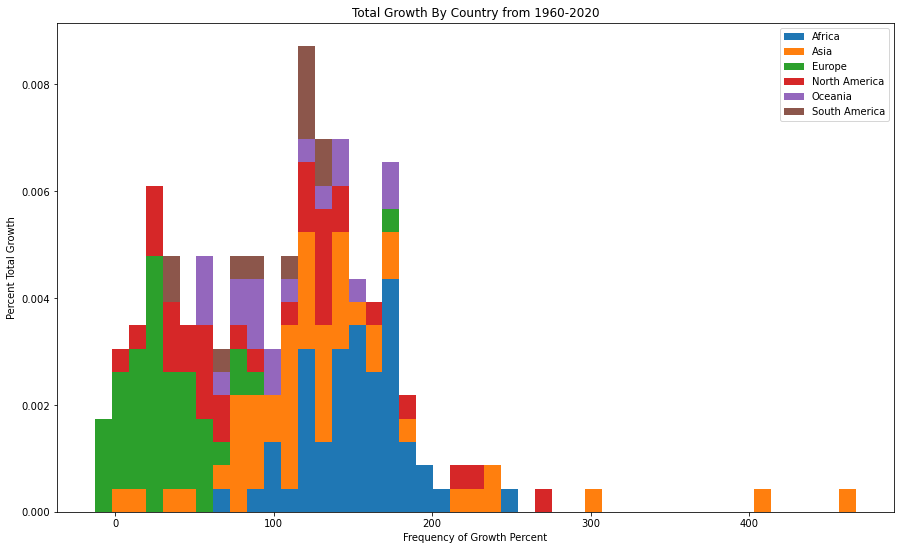

In [42]:
plt.hist([Afr['sum'], Asi['sum'], Eur['sum'], Nor['sum'], Oce['sum'], Sou['sum']], density = True, histtype = 'bar', bins = 45, label = ['Africa','Asia','Europe', 'North America', 'Oceania', 'South America'], stacked=True)
    
plt.legend(loc = "upper right")
plt.title('Total Growth By Country from 1960-2020')
plt.ylabel("Percent Total Growth")
plt.xlabel("Frequency of Growth Percent")
plt.savefig('./Images/Country_Growth.jpg', bbox_inches='tight')
plt.show()

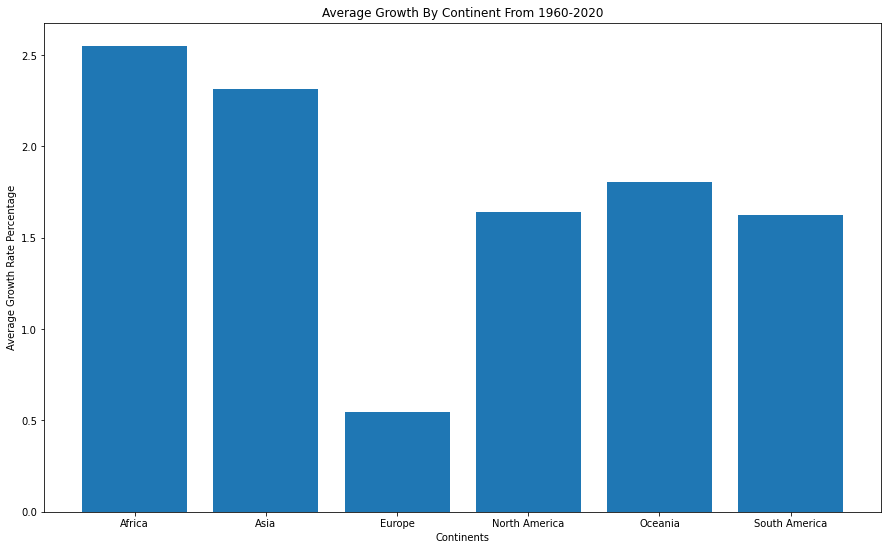

In [43]:
avgs_by_continent = pop_growth_avg.groupby('Continent_Name')['avg'].mean()
continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']

plt.bar(continents, avgs_by_continent)
plt.title('Average Growth By Continent From 1960-2020')
plt.ylabel("Average Growth Rate Percentage")
plt.xlabel("Continents")
plt.savefig('./Images/Average_Growth_By_Continent.jpg', bbox_inches='tight')
plt.show()

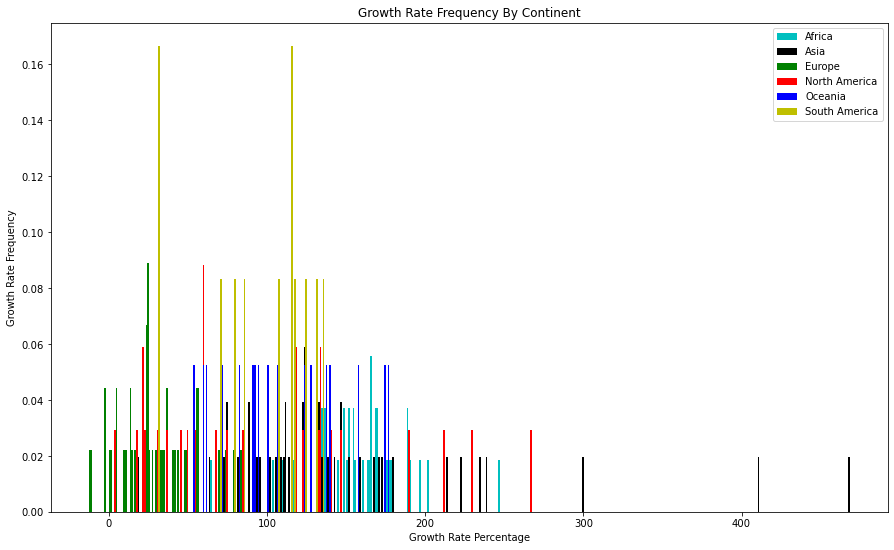

In [44]:
# This chart is difficult to read and not usable for any purpose other than extracting very specific
# information. This displays total growth rate by frequency of other countries expeirencing the same growth
# rate. Notably this means a lot of overlap due to the special outliers represented in Asia.

bins = np.arange(min(pop_growth_avg['sum']), max(pop_growth_avg['sum']) + 1, 1)

Afr = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'Africa']
Asi = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'Asia']
Eur = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'Europe']
Nor = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'North America']
Oce = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'Oceania']
Sou = pop_growth_avg.loc[pop_growth_avg['Continent_Name'] == 'South America']

plt.hist(Afr['sum'], bins, density = 1, histtype = 'bar', label = 'Africa', color = 'c')
plt.hist(Asi['sum'], bins, density = 1, histtype = 'bar', label = 'Asia', color = 'k')
plt.hist(Eur['sum'], bins, density = 1, histtype = 'bar', label = 'Europe', color = 'g')
plt.hist(Nor['sum'], bins, density = 1, histtype = 'bar', label = 'North America', color = 'r')
plt.hist(Oce['sum'], bins, density = 1, histtype = 'bar', label = 'Oceania', color = 'b')
plt.hist(Sou['sum'], bins, density = 1, histtype = 'bar', label = 'South America', color = 'y')

plt.ylabel("Growth Rate Frequency")
plt.xlabel("Growth Rate Percentage")

plt.legend(loc="upper right")
plt.title('Growth Rate Frequency By Continent')
plt.savefig('./Images/Growth_Rate_Frequency.jpg', bbox_inches='tight')
plt.show()

In [45]:
def meanByContinentByYear(data):
    data = pd.DataFrame(data.mean().to_dict(),index = [data.index.values[-1]])
    data = data.drop(columns=['Country_Number', 'sum', 'avg'])
    return data

In [46]:
ContinentalGrowthAvgByYear = meanByContinentByYear(Afr)

ContinentalGrowthAvgByYear = ContinentalGrowthAvgByYear.append(meanByContinentByYear(Asi), ignore_index = True)
ContinentalGrowthAvgByYear = ContinentalGrowthAvgByYear.append(meanByContinentByYear(Eur), ignore_index = True)
ContinentalGrowthAvgByYear = ContinentalGrowthAvgByYear.append(meanByContinentByYear(Nor), ignore_index = True)
ContinentalGrowthAvgByYear = ContinentalGrowthAvgByYear.append(meanByContinentByYear(Oce), ignore_index = True)
ContinentalGrowthAvgByYear = ContinentalGrowthAvgByYear.append(meanByContinentByYear(Sou), ignore_index = True)

ContinentalGrowthAvgByYear = ContinentalGrowthAvgByYear.drop(columns=['Continent_Code'])

ContinentalGrowthAvgByYear = ContinentalGrowthAvgByYear.transpose()

ContinentalGrowthAvgByYear.columns = continents

ContinentalGrowthAvgByYear.head(10)

<ipython-input-45-2870406b2b00>:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Africa,Asia,Europe,North America,Oceania,South America
[1961],2.260088,3.005375,1.256248,2.431787,2.716057,2.551628
[1962],2.283184,3.155407,1.261468,2.307620,2.907490,2.524440
[1963],2.323121,3.173248,1.236324,2.580545,2.860281,2.491922
[1964],2.384156,3.135930,1.211507,2.223503,2.854667,2.454482
[1965],2.456685,3.086733,1.127351,2.332202,2.731320,2.412118
[1966],2.539991,2.984446,1.055217,2.235208,2.674028,2.373900
[1967],2.609954,3.007229,1.014180,2.218967,2.542466,2.330654
[1968],2.639345,2.943475,0.953064,2.390938,2.435088,2.262818
[1969],2.620152,2.966672,0.878193,2.210469,2.448584,2.166728
[1970],2.575030,3.023316,0.823398,2.123652,2.562956,2.055237


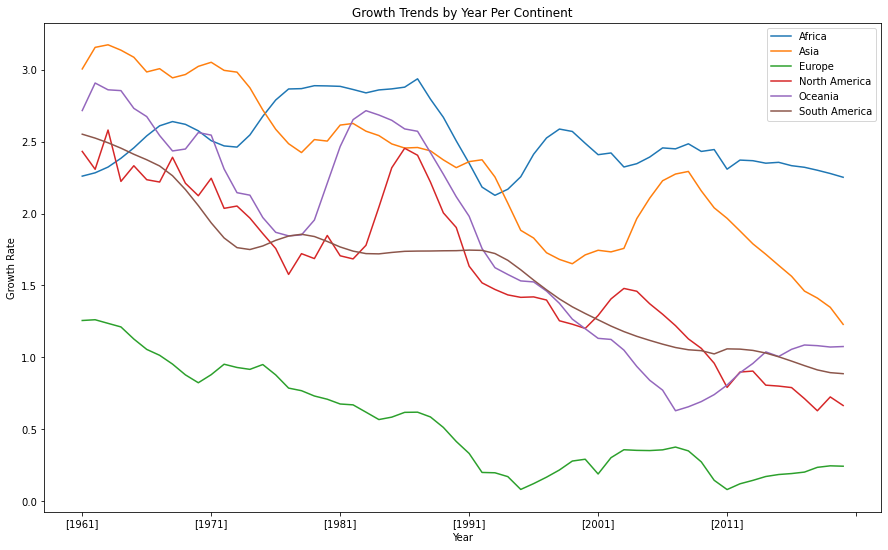

In [47]:
ContinentalGrowthAvgByYear.plot.line(xlabel = 'Year', ylabel = 'Growth Rate', title = 'Growth Trends by Year Per Continent')
plt.savefig('./Images/Growth_Trends_by_Year_Per_Continent.jpg', bbox_inches='tight')

<ipython-input-48-75600b8e6785>:9: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



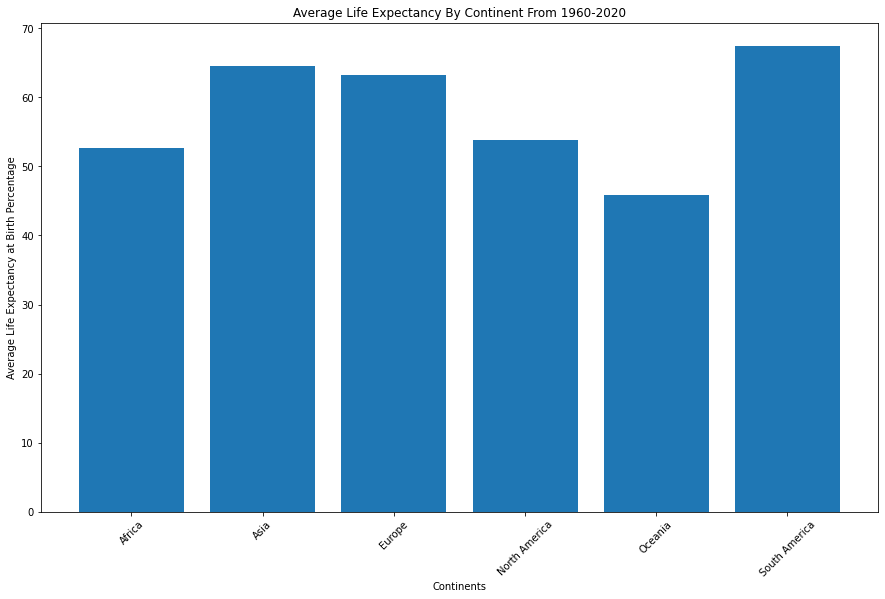

In [48]:
# prepare df for life expectancy analysis
pop_le_avg = pop_life_expec.copy()
pop_le_avg = pop_le_avg.drop(pop_le_avg.loc[:, 'Series_Name':'[1960]'].columns, axis = 1)
pop_le_avg = pop_le_avg.drop(pop_le_avg.loc[:, '[2021]':'[2050]'].columns, axis = 1)
pop_le_avg = pop_le_avg.apply(pd.to_numeric, errors='ignore')

#sum and avg of each country

pop_le_avg['sum'] = pop_le_avg.sum(axis=1)
pop_le_avg['sum'] = pop_le_avg['sum'] - pop_le_avg['Country_Number']
pop_le_avg['avg'] = pop_le_avg['sum']/59 #Difference in years 1961 - 2020


Afr_le = pop_le_avg.loc[pop_le_avg['Continent_Name'] == 'Africa']
Asi_le = pop_le_avg.loc[pop_le_avg['Continent_Name'] == 'Asia']
Eur_le = pop_le_avg.loc[pop_le_avg['Continent_Name'] == 'Europe']
Nor_le = pop_le_avg.loc[pop_le_avg['Continent_Name'] == 'North America']
Oce_le = pop_le_avg.loc[pop_le_avg['Continent_Name'] == 'Oceania']
Sou_le = pop_le_avg.loc[pop_le_avg['Continent_Name'] == 'South America']

avgs_by_continent_le = pop_le_avg.groupby('Continent_Name')['avg'].mean()
continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']

plt.bar(continents, avgs_by_continent_le)
plt.title('Average Life Expectancy By Continent From 1960-2020')
plt.ylabel("Average Life Expectancy at Birth Percentage")
plt.xlabel("Continents")
plt.savefig('./Images/Average_Life_Expectancy_Continent.jpg', bbox_inches='tight')
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

<ipython-input-45-2870406b2b00>:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



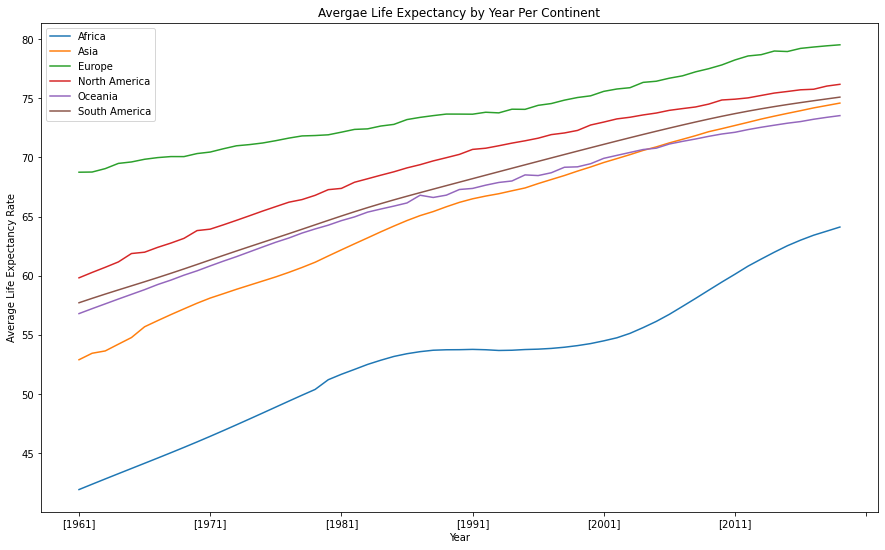

In [49]:
Continental_Le_AvgByYear = meanByContinentByYear(Afr_le)

Continental_Le_AvgByYear = Continental_Le_AvgByYear.append(meanByContinentByYear(Asi_le), ignore_index = True)
Continental_Le_AvgByYear = Continental_Le_AvgByYear.append(meanByContinentByYear(Eur_le), ignore_index = True)
Continental_Le_AvgByYear = Continental_Le_AvgByYear.append(meanByContinentByYear(Nor_le), ignore_index = True)
Continental_Le_AvgByYear = Continental_Le_AvgByYear.append(meanByContinentByYear(Oce_le), ignore_index = True)
Continental_Le_AvgByYear = Continental_Le_AvgByYear.append(meanByContinentByYear(Sou_le), ignore_index = True)

Continental_Le_AvgByYear = Continental_Le_AvgByYear.drop(columns=['Continent_Code'])

Continental_Le_AvgByYear = Continental_Le_AvgByYear.transpose()

Continental_Le_AvgByYear.columns = continents

Continental_Le_AvgByYear.plot.line(xlabel = 'Year', ylabel = 'Average Life Expectancy Rate', title = 'Avergae Life Expectancy by Year Per Continent')
plt.savefig('./Images/Avg_Life_expectancy_by_Year_Per_Continent.jpg', bbox_inches='tight')

In [50]:
# General visualizations - male population vs female population
pop_male_plot = preparePlot(pop_male)
pop_female_plot = preparePlot(pop_female)

In [51]:
pop_male_plot.head(5)

,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,"Bahamas, The",Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,British Virgin Islands,Brunei Darussalam,Bulgaria,Burkina Faso,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Cayman Islands,Central African Republic,Chad,Chile,China,Colombia,Comoros,"Congo, Dem. Rep.","Congo, Rep.",Costa Rica,Cote d'Ivoire,Croatia,Cuba,Curacao,Cyprus,Czech Republic,Denmark,Djibouti,Dominica,Dominican Republic,Ecuador,"Egypt, Arab Rep.",El Salvador,Equatorial Guinea,Eritrea,Estonia,Eswatini,Ethiopia,Faroe Islands,Fiji,Finland,France,French Polynesia,Gabon,"Gambia, The",Georgia,Germany,Ghana,Gibraltar,Greece,Greenland,Grenada,Guam,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,"Hong Kong SAR, China",Hungary,Iceland,India,Indonesia,"Iran, Islamic Rep.",Iraq,Ireland,Isle of Man,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kiribati,"Korea, Dem. People's Rep.","Korea, Rep.",Kuwait,Kyrgyz Republic,Lao PDR,Latvia,Lebanon,Lesotho,Liberia,Libya,Liechtenstein,Lithuania,Luxembourg,"Macao SAR, China",Madagascar,Malawi,Malaysia,Maldives,Mali,Malta,Marshall Islands,Mauritania,Mauritius,Mexico,"Micronesia, Fed. Sts.",Moldova,Monaco,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nauru,Nepal,Netherlands,New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,North Macedonia,Northern Mariana Islands,Norway,Oman,Pakistan,Palau,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Puerto Rico,Qatar,Romania,Russian Federation,Rwanda,Samoa,San Marino,Sao Tome and Principe,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Sint Maarten (Dutch part),Slovak Republic,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,St. Kitts and Nevis,St. Lucia,St. Martin (French part),St. Vincent and the Grenadines,Sudan,Suriname,Sweden,Switzerland,Syrian Arab Republic,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Tonga,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,Turks and Caicos Islands,Tuvalu,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),West Bank and Gaza,"Yemen, Rep.",Zambia,Zimbabwe
[1961],51.587311,51.402612,50.244232,NaN,NaN,50.758741,46.808472,50.387390,48.264175,49.034888,50.455962,46.611464,47.936829,48.065046,53.793650,51.955637,44.853658,45.283170,49.184665,49.414995,47.630507,NaN,50.949316,49.581652,49.117741,48.540243,49.798865,NaN,51.598878,49.939347,50.763824,48.315336,46.946489,49.898382,49.215641,50.508905,NaN,49.235907,48.858943,49.972037,51.516145,49.519022,49.751480,47.845815,49.146838,50.802317,51.435683,48.067840,51.053318,49.974296,49.156838,48.643280,49.606147,49.710179,NaN,50.620178,50.015361,50.885239,49.283690,49.095005,49.713448,44.313793,48.478503,49.712633,NaN,51.471108,48.198618,48.546116,51.389629,48.849430,49.906561,46.640794,46.617640,50.825162,NaN,49.034599,NaN,46.488327,58.004848,50.634529,49.443592,49.244967,50.163252,49.093952,50.135494,51.572820,48.225084,50.536602,51.630037,49.705441,51.339513,50.365849,50.235035,NaN,50.696245,48.621558,48.018282,49.225046,52.265594,48.141674,50.158594,49.365440,46.319518,50.374545,64.130135,47.543739,49.152483,44.291316,50.298856,44.320266,50.484897,51.331041,NaN,46.199185,49.303801,49.307780,50.797894,48.971812,50.884807,54.274976,50.494047,48.453949,NaN,49.514953,49.887932,49.899198,51.509611,46.795062,NaN,49.175457,48.796195,49.748253,48.923042,49.199847,49.151514,NaN,49.876608,49.801592,52.708455,50.233203,49.930155,47.253467,49.922674,50.614700,NaN,49.813120,49.435555,53.509533,NaN,51.018062,51.662174,49.280500,50.165728,50.370623,48.414221,47.776993,49.244364,57.337585,48.868149,44.904129,49.109939,50.710896,NaN,55.270369,50.236676,49.748792,49.235804,48.984927,48.963131,52.500829,NaN,49.392601,47.891521,53.486016,49.470830,49.823553,50.177251,48.603944,52.

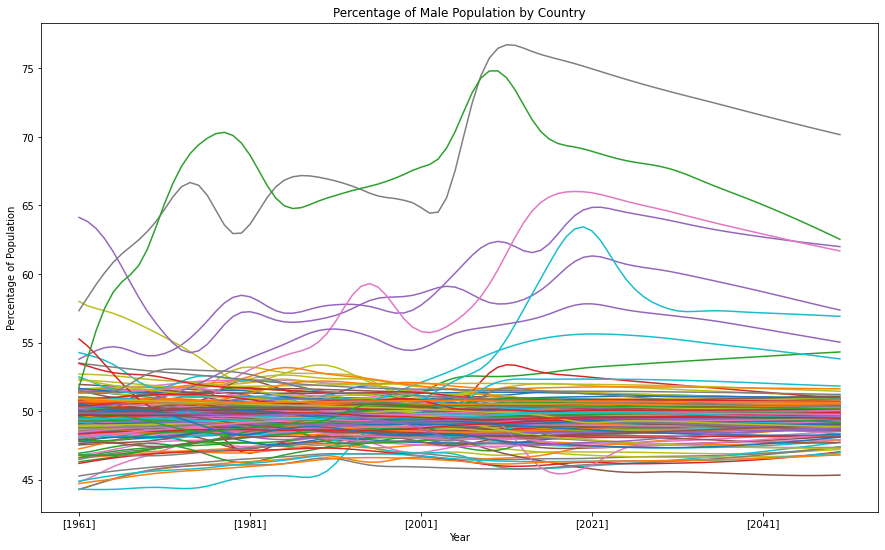

In [52]:
pop_male_plot.plot.line(xlabel = 'Year', ylabel = 'Percentage of Population', title = 'Percentage of Male Population by Country', legend=False)
plt.savefig('./Images/Percent_Male_Population_by_Country.jpg', bbox_inches='tight')

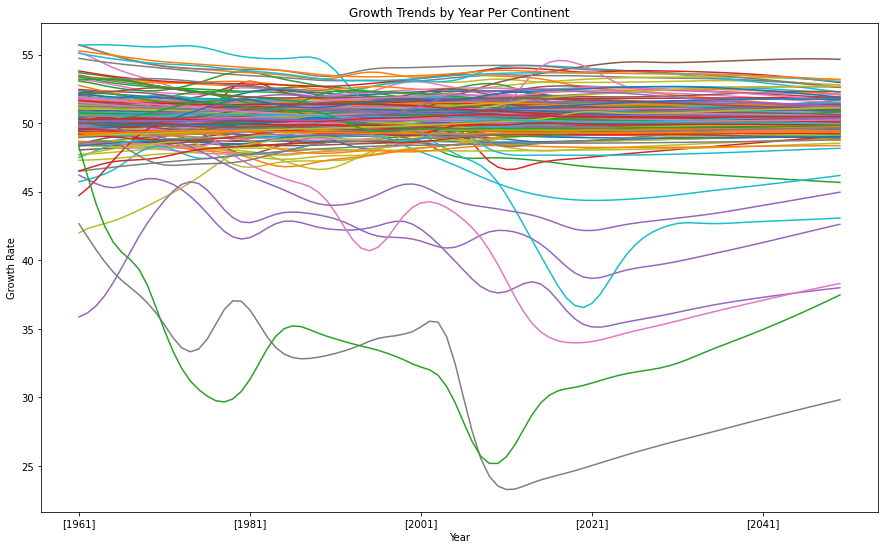

In [53]:
pop_female_plot.plot.line(xlabel = 'Year', ylabel = 'Growth Rate', title = 'Growth Trends by Year Per Continent', legend=False)
plt.savefig('./Images/Percent_Female_Population_by_Country.jpg', bbox_inches='tight')

In [54]:
#We should look into why these outlier countries have such a dramatic decrease of women, and increase of men.
#They are obviously directly related 

In [55]:
# Now that we have completed some initial visualizations of our data we will begin to model using different
# methods and models.

In [56]:
# First we will conduct some K-Nearest Neighbors in an attempt to see if we can label the data in some
# interesting fashion.

In [57]:
# Preparing our dataset for use in KNN
# We will begin by conducting KNN on the population totals by country.

Model_data_pop_totals = pop_total
Model_data_pop_totals = Model_data_pop_totals.drop(['Continent_Code', 'Country_Number', 'Country_Name', 
                                                'Country_Code', 'Series_Name', 'Series_Code'], axis=1)

# We want to only use data from 1960-2020 (not projected data) so we will remove them below.
Model_data_pop_totals = Model_data_pop_totals.iloc[:, 0:62]
Model_data_pop_totals = Model_data_pop_totals.dropna(axis=0) 
Model_data_pop_totals.head(5)

,Continent_Name,[1960],[1961],[1962],[1963],[1964],[1965],[1966],[1967],[1968],[1969],[1970],[1971],[1972],[1973],[1974],[1975],[1976],[1977],[1978],[1979],[1980],[1981],[1982],[1983],[1984],[1985],[1986],[1987],[1988],[1989],[1990],[1991],[1992],[1993],[1994],[1995],[1996],[1997],[1998],[1999],[2000],[2001],[2002],[2003],[2004],[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020]
62,Asia,8996967,9169406,9351442,9543200,9744772,9956318,10174840,10399936,10637064,10893772,11173654,11475450,11791222,12108963,12412960,12689164,12943093,13171294,13341199,13411060,13356500,13171679,12882518,12537732,12204306,11938204,11736177,11604538,11618008,11868873,12412311,13299016,14485543,15816601,17075728,18110662,18853444,19357126,19737770,20170847,20779957,21606992,22600774,23680871,24726689,25654274,26433058,27100542,27722281,28394806,29185511,30117411,31161378,32269592,33370804,34413603,35383028,36296111,37171922,38041757,38928341
152,Europe,1608800,1659800,1711319,1762621,1814135,1864791,1914573,1965598,2022272,2081695,2135479,2187853,2243126,2296752,2350124,2404831,2458526,2513546,2566266,2617832,2671997,2726056,2784278,2843960,2904429,2964762,3022635,3083605,3142336,3227943,3286542,3266790,3247039,3227287,3207536,3187784,3168033,3148281,3128530,3108778,3089027,3060173,3051010,3039616,3026939,3011487,2992547,2970017,2947314,2927519,2913021,2905195,2900401,2895092,2889104,2880703,2876101,2873457,2866376,2854191,2837743
242,Africa,11057864,11336336,11619828,11912800,12221675,12550880,12902626,13275020,13663581,14061724,14464992,14872253,15285992,15709831,16149018,16607706,17085799,17582899,18102266,18647801,19221659,19824297,20452901,21101875,21763578,22431507,23102386,23774287,24443472,25106192,25758872,26400468,27028330,27635517,28213777,28757788,29266415,29742980,30192750,30623406,31042238,31451513,31855110,32264159,32692153,33149720,33641007,34166976,34730604,35333882,35977451,36661438,37383899,38140135,38923688,39728020,40551398,41389174,42228415,43053054,43851043
332,Oceania,20127,20605,21246,22029,22850,23675,24473,25235,25980,26698,27362,27982,28564,29103,29595,30045,30455,30834,31262,31842,32648,33697,34969,36413,37946,39521,41114,42741,44346,45894,47351,48682,49900,51025,52099,53158,54209,55227,56180,57049,57816,58496,59077,59495,59684,59557,59109,58367,57490,56675,56084,55755,55669,55717,55791,55806,55739,55617,55461,55312,55197
422,Europe,13410,14378,15379,16407,17466,18542,19646,20760,21886,23053,24275,25571,26885,28232,29515,30705,31782,32769,33744,34825,36063,37498,39115,40854,42706,44593,46520,48459,50433,52452,54508,56666,58882,60974,62676,63860,64363,64318,64140,64368,65390,67344,70048,73180,76250,78871,80995,82682,83860,84461,84454,83748,82427,80770,79213,77993,77295,76997,77008,77146,77265


In [58]:
# Here we will apply KNN to our dataset to see which countries are similar when looking purely at 
# their population totals. 

X = Model_data_pop_totals.drop(['Continent_Name'], axis=1)
y = Model_data_pop_totals.Continent_Name
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40)

In [59]:
KNN = KNeighborsClassifier(n_neighbors = 6) #Number of continents for labelling
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [60]:
prediction = KNN.predict(X_test)
accuracy_score(prediction, y_test)

0.4470588235294118

In [61]:
# As we can see, applying KNN to properly cluster the data by continent has given us roughly 50% accuracy.
# Running this multiple times continues to change the %, Not sure what this means but we should investigate.

In [62]:
print(confusion_matrix(y_test, prediction))

[[15  8  0  2  0  0]
 [ 5 11  1  5  0  0]
 [ 0  3  9  2  0  0]
 [ 3  0  3  3  0  0]
 [ 0  2  1  5  0  0]
 [ 3  3  1  0  0  0]]


In [63]:
# The corresponding confusion matrix provides us with a more interesting visualization which shows that
# How the data is being split

# Next we will make a K-Means attempt at clustering the data, once again trying to get a better accuracy than
# What was previously created. This time however we expect better results because the act of clustering,
# should be better suited to our population trends if we assume neigboring countries will experience similar
# population trends.

In [64]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [65]:
num = []
data = []
scores = []

for i in range(2,15):
    km = KMeans(n_clusters = i)
    km.fit(X_scaled)
    pred = KNN.predict(X_test)
    print("Score for number of clusters {}: {}".format(i,km.score(X_scaled)))
    scores.append(-km.score(X_scaled))
    num.append(i)
    data.append(-km.score(X_scaled))

Score for number of clusters 2: -12.615943979532242
Score for number of clusters 3: -5.318784743758249
Score for number of clusters 4: -3.4466916427511873
Score for number of clusters 5: -1.8359778342342692
Score for number of clusters 6: -1.106809531720458
Score for number of clusters 7: -0.7901640233241989
Score for number of clusters 8: -0.5503616051802224
Score for number of clusters 9: -0.44357282087065947
Score for number of clusters 10: -0.34033976989589376
Score for number of clusters 11: -0.2798437893699537
Score for number of clusters 12: -0.21919430813619475
Score for number of clusters 13: -0.17839536469860273
Score for number of clusters 14: -0.15968490524448767


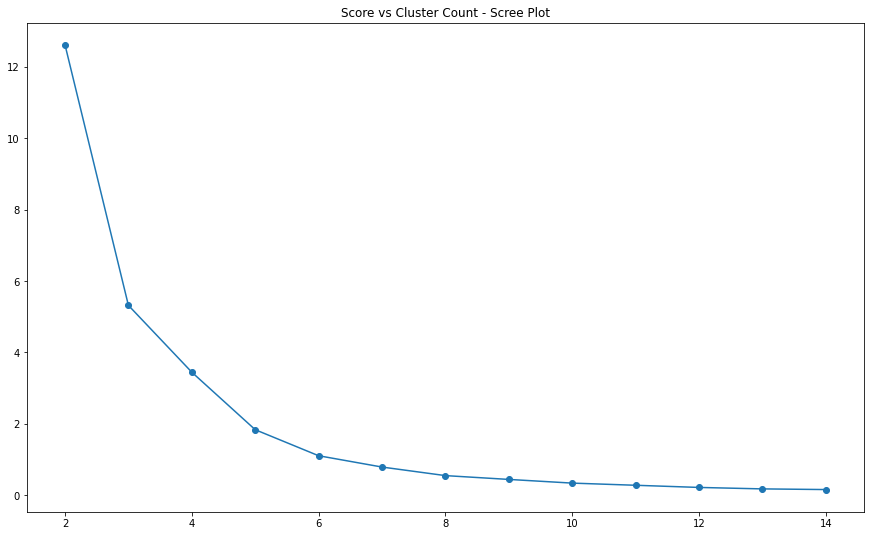

In [66]:
# Scree plot of our individual cluster scores
plt.plot(num, data, 'o-')
plt.title('Score vs Cluster Count - Scree Plot')
plt.savefig('./Images/Cluster_Scree_Plot.png', bbox_inches='tight')
plt.show()

In [67]:
# As demonstraed in the scree plot above we can see that there is a minor elbow in the data at a cluster
# count of 6. This is intuitive and interesting, because this may demonstrate that the number of continets
# was a good KNN decision. # Moving forward we can use PCA to reduce the dimensions to see if there are 
# any interesting patterns which emerge in the data.

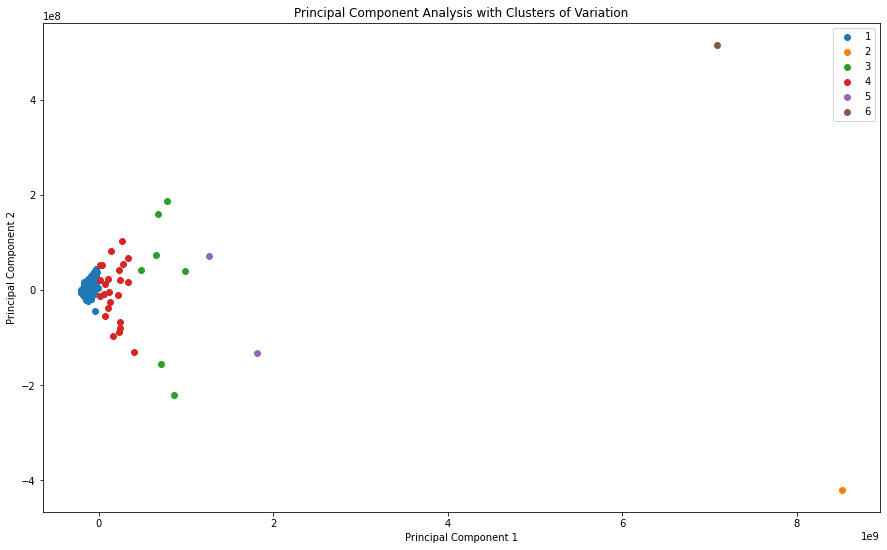

In [68]:
PCADATA = PCA(2)
pca = PCADATA.fit_transform(X) # X is our population totals without the inital first few columns
km = KMeans(n_clusters = 6)
label = km.fit_predict(pca)
setofLabels = np.unique(label)
for i in setofLabels:
    plt.scatter(pca[label == i , 0] , pca[label == i , 1] , label = i+1)
plt.legend()
plt.title('Principal Component Analysis with Clusters of Variation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('./Images/PCA_Clustered_Population_Totals.png', bbox_inches='tight')
plt.show()

In [69]:
# Given our immense amount of data it was imperative to use PCA to reduce the dimension to two inorder for 
# a proper plotting of the data.After PCA we can now demonstrate the the graph itself and how the different 
# sections are clustered. There appears to be a VERY tight cluster around (0, 0) with the addition of a few 
# intense outliers. This is somewhat expected given that there are a few countries that have had IMMENSE 
# growth over the last century.